In [2]:
%cd drive/My\ Drive/colab/dncnn

/content/drive/My Drive/colab/dncnn


In [3]:
from tensorflow.keras import Model
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU


class DnCNN(Model):
    def __init__(self, depth=20):
        super(DnCNN, self).__init__()
        self.conv1 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=he_uniform())
        self.conv_bn_relu = [ConvBNReLU() for i in range(depth - 2)]
        self.conv_final = Conv2D(1, 3, padding='same', kernel_initializer=he_uniform())

    def call(self, x):
        x = self.conv1(x)
        for cbr in self.conv_bn_relu:
            x = cbr(x)
        return self.conv_final(x)


class ConvBNReLU(Model):
    def __init__(self):
        super(ConvBNReLU, self).__init__()
        self.conv = Conv2D(64, 3, padding='same', kernel_initializer=he_uniform())
        self.bn = BatchNormalization()
        self.relu = ReLU()

    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x)


In [42]:
class DnCNNRN(Model):
    def __init__(self, depth=8):
        super(DnCNNRN, self).__init__()
        
        self.conv1 = Conv2D(64, 3, padding='same', kernel_initializer=he_uniform())
        #self.bn1 = BatchNormalization()
        self.relu1 = ReLU()

        self.rn_layers = [BasicBlock() for i in range(depth)]

        self.conv_final = Conv2D(1, 3, padding='same', kernel_initializer=he_uniform())

    def call(self, x):
        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.relu1(x)
        for layer in self.rn_layers:
            x = layer(x)
        return self.conv_final(x)


class BasicBlock(Model):
    def __init__(self):
        super(BasicBlock, self).__init__()
        self.conv1 = Conv2D(64, 3, padding='same', kernel_initializer=he_uniform())
        self.bn1 = BatchNormalization()
        self.relu = ReLU()
        self.conv2 = Conv2D(64, 3, padding='same', kernel_initializer=he_uniform())
        self.bn2 = BatchNormalization()

    def call(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity

        out = self.relu(out)

        return out

In [43]:
import random

import matplotlib.pyplot as plt
import tensorflow as tf
#from dncnn import DnCNN
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

In [44]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    return img  # tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img


def gaussian_noise_layer(dim):
    std = 25#random.randint(0, 55)
    noise = tf.random.normal(shape=[dim, dim, 1], mean=0.0, stddev=std / 255.0, dtype=tf.float32)
    return noise


def augment(image):
    image = tf.io.read_file(image)
    image = decode_img(image)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.random_crop(image, size=[40, 40, 1])
    image = tf.image.convert_image_dtype(image, tf.float32)
    noise = gaussian_noise_layer(40)

    return image+noise, noise, image

In [52]:
@tf.function
def train_step(images, targets, true):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(targets, predictions)
        metric = tf.image.psnr(images-predictions, true,  max_val=1.0)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_metric(metric)


batch_size = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

data_dir = 'data/train/*.jpg'

train_ds = tf.data.Dataset.list_files(data_dir)


# train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)


def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = configure_for_performance(train_ds)

#image_batch, target_batch = next(iter(train_ds))

'''plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().squeeze(), cmap='gray')
    plt.axis("off")'''

model = DnCNN()

loss_object = MeanSquaredError()

optimizer = Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_metric = tf.keras.metrics.Mean(name='train_metric')
EPOCHS = 1000

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_metric.reset_states()
    for images, targets, true in train_ds:
        train_step(images, targets, true)

    template = 'Epoch {}, Loss: {}, PSNR: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_metric.result()))


Epoch 1, Loss: 0.5809949636459351, PSNR: 6.049780368804932
Epoch 2, Loss: 0.08093865215778351, PSNR: 13.002593040466309
Epoch 3, Loss: 0.01983322761952877, PSNR: 17.610074996948242
Epoch 4, Loss: 0.013351249508559704, PSNR: 18.95299530029297
Epoch 5, Loss: 0.01157321035861969, PSNR: 19.4620418548584
Epoch 6, Loss: 0.010709808208048344, PSNR: 19.735462188720703
Epoch 7, Loss: 0.010472121648490429, PSNR: 19.83301544189453
Epoch 8, Loss: 0.010216479189693928, PSNR: 19.93090057373047
Epoch 9, Loss: 0.009980442002415657, PSNR: 20.013744354248047
Epoch 10, Loss: 0.009953798726201057, PSNR: 20.038169860839844
Epoch 11, Loss: 0.009853340685367584, PSNR: 20.071666717529297
Epoch 12, Loss: 0.009821380488574505, PSNR: 20.08079719543457
Epoch 13, Loss: 0.009755661711096764, PSNR: 20.111879348754883
Epoch 14, Loss: 0.009687155485153198, PSNR: 20.14777374267578
Epoch 15, Loss: 0.009686396457254887, PSNR: 20.144954681396484
Epoch 16, Loss: 0.009638785384595394, PSNR: 20.178098678588867
Epoch 17, Loss

In [53]:
model.save_weights('weights/vgg')

In [59]:
@tf.function
def test_step(images, labels, true):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)
  t_metric = tf.image.psnr(images-predictions, true,  max_val=1.0)

  test_loss(t_loss)
  test_metric(t_metric)
  

def augment_test(image):
    image = tf.io.read_file(image)
    image = decode_img(image)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize_with_crop_or_pad(image, 180, 180)
    image = tf.image.convert_image_dtype(image, tf.float32)
    noise = gaussian_noise_layer(180)

    return image + noise, noise, image

def configure_for_test(ds):
    ds = ds.cache()
    ds = ds.map(augment_test, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

test_dir = 'data/test/*.jpg'

model = DnCNN()
model.load_weights('weights/vgg')


test_loss = tf.keras.metrics.Mean(name='test_loss')
test_metric = tf.keras.metrics.Mean(name='test_metric')
test_loss.reset_states()
test_metric.reset_states()
test_ds = tf.data.Dataset.list_files(test_dir)
test_ds = configure_for_test(test_ds)


for test_images, test_labels, test_true in test_ds:
    test_step(test_images, test_labels, test_true)
print(test_loss.result())
print(test_metric.result())

tf.Tensor(0.0022140988, shape=(), dtype=float32)
tf.Tensor(26.809841, shape=(), dtype=float32)


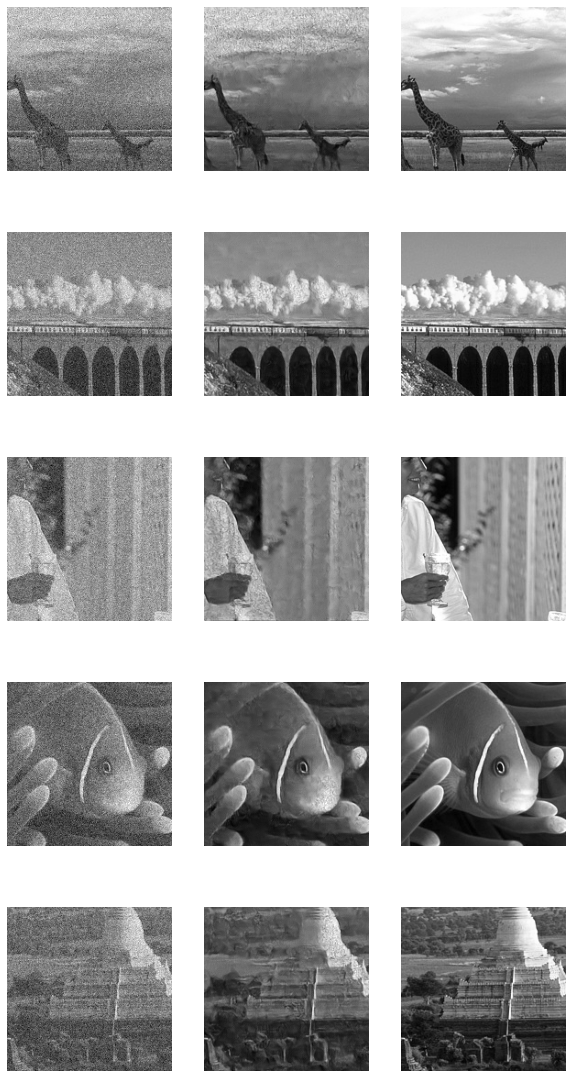

In [56]:
image_batch, target_batch, true_batch = next(iter(test_ds))
predictions = model(image_batch, training=False)


columns = 3
rows = 5
fig = plt.figure(figsize=(10, 20))
for i in range(rows):
    fig.add_subplot(rows,columns,1+(i*columns))
    plt.imshow(image_batch[i].numpy().squeeze(), cmap='gray')
    plt.axis("off")
    fig.add_subplot(rows,columns,2+(i*columns))
    plt.imshow((image_batch[i]-predictions[i]).numpy().squeeze(), cmap='gray')
    plt.axis("off")
    fig.add_subplot(rows,columns,3+(i*columns))
    plt.imshow(true_batch[i].numpy().squeeze(), cmap='gray')
    plt.axis("off")

plt.show()


In [57]:
def augment_12(image):
    image = tf.io.read_file(image)
    image = tf.image.decode_png(image,1)
    #image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize_with_crop_or_pad(image, 180, 180)
    image = tf.image.convert_image_dtype(image, tf.float32)
    noise = gaussian_noise_layer(180)

    return image + noise, noise, image

def configure_for_12(ds):
    ds = ds.cache()
    ds = ds.map(augment_12, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(12)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

dir_12 = 'data/12/*.png'

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_metric = tf.keras.metrics.Mean(name='test_metric')
test_loss.reset_states()
test_metric.reset_states()
ds_12 = tf.data.Dataset.list_files(dir_12)
ds_12 = configure_for_12(ds_12)


for test_images, test_labels, test_true in ds_12:
    test_step(test_images, test_labels, test_true)
print(test_loss.result())
print(test_metric.result())

tf.Tensor(0.0017509445, shape=(), dtype=float32)
tf.Tensor(27.742498, shape=(), dtype=float32)


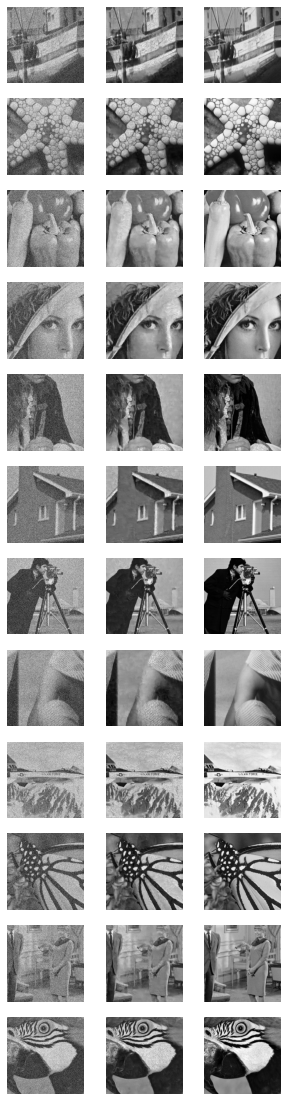

In [58]:
image_batch, target_batch, true_batch = next(iter(ds_12))
predictions = model(image_batch, training=False)


columns = 3
rows = 12
fig = plt.figure(figsize=(5, 20))
for i in range(rows):
    fig.add_subplot(rows,columns,1+(i*columns))
    plt.imshow(image_batch[i].numpy().squeeze(), cmap='gray')
    plt.axis("off")
    fig.add_subplot(rows,columns,2+(i*columns))
    plt.imshow((image_batch[i]-predictions[i]).numpy().squeeze(), cmap='gray')
    plt.axis("off")
    fig.add_subplot(rows,columns,3+(i*columns))
    plt.imshow(true_batch[i].numpy().squeeze(), cmap='gray')
    plt.axis("off")

plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('tmp/model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    # Get sample input data as a numpy array in a method of your choosing.
    yield [input]
converter.representative_dataset = representative_dataset_gen
tflite_quant_model = converter.convert()